---
layout: chapter
title: Removing background waves with Harmonic Inversion
---

# Removing background waves with Harmonic Inversion

A first examination of the turbulence data reveals the presence of
background waves in the tank. These waves are remnants of the
filling process. Ideally the tank would have been allowed to settle
completely before an experiment was performed but logistical
contraints prevented this from occuring: the tank forms an efficient
wave guide and the time needed for wave decay would have been on the
order of one hour.

As it is, the waves form a strong and detectable signal in the data.
The challenge is to isolate and remove this signal. With the
assumption that the waves combine linearly with the gravity current
this can be done easily by subtracting the wave signal.


## Isolation of the signal

### Frame comparison

A first approximation to removing the background wave field is to
use the differnce between the current relative and lab relative
frames to attempt to isolate the wave field.

**Show work from last May with the summation and averaging of the
waves**

This is nearly satisfactory, but doesn't quite work.


### Harmonic Inversion

At first glance, this would appear to be exactly the problem that
the fourier transform solves. However, the fourier transform lacks
resolution for closely spaced frequencies:

In [5]:
# Plot a figure showing the fourier transform results

A more robust means of removing the background signal would be to
use our assumptions about the character of the signal in a more
formal way. *Given that* our background signal consists of a sum of
sinusoidal modes, we wish to determine the frequencies and
amplitudes of those mdoes - this is the problem of *harmonic
inversion*.

"Harmonic inversion of time signals," J.  Chem.  Phys.  107, 6756 (1997)

In [12]:
import gc_turbulence as g
%matplotlib inline

index = 'r14_01_14a'
cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

As we might expect, there are no waves in the mean front relative data:

<matplotlib.colorbar.Colorbar instance at 0x2ba8f77bfea8>

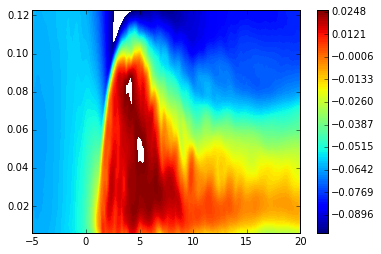

In [13]:
mean = np.mean(r.Uf[...], axis=1)
plt.contourf(tf, zf, mean, levels=u_levels)
plt.colorbar()

If we subtract the mean from the data and look at a single vertical
slice we can see waves:

<matplotlib.colorbar.Colorbar instance at 0x2ba9031653f8>

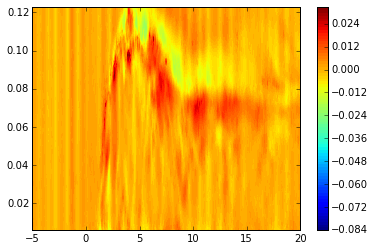

In [179]:
mean_subtracted = r.Uf[...] - mean[..., None, ...]
c = plt.contourf(tf, zf, mean_subtracted[:, 30, :], 100)
plt.colorbar()

<matplotlib.contour.QuadContourSet instance at 0x2ba8fd2a4320>

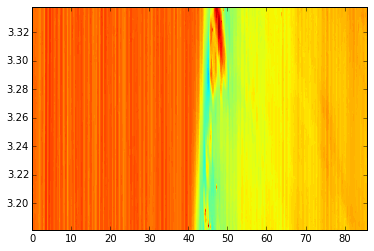

In [5]:
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]
plt.contourf(Te, r.X[0], mean_u, levels=u_levels)

### aside: Dynamic mode decomposition

In [ ]:
import sparse_dmd


snaps = sparse_dmd.to_snaps(mean_u)
dmd = sparse_dmd.DMD(snaps, dt=0.01)
dmd.compute()

In [47]:
spdmd = sparse_dmd.SparseDMD(dmd=dmd)
gamma = np.logspace(-6, -1, 20)
spdmd.compute_sparse(gamma)

splots = sparse_dmd.SparsePlots(spdmd)

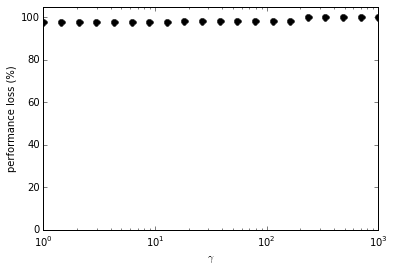

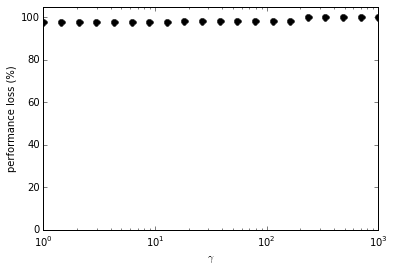

In [45]:
splots.performance_loss_gamma()

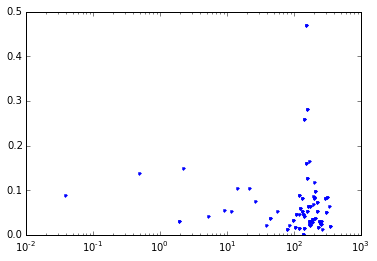

In [54]:
plt.semilogx(-dmd.frequencies.real, np.abs(dmd.amplitudes), '.')

A better way to get the signal:

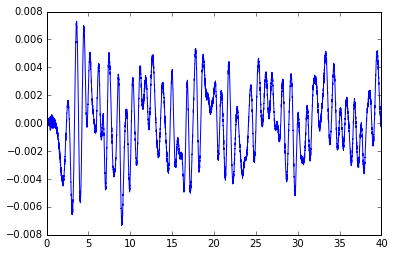

In [6]:
signal = np.mean(r.U[-10:, :, :], axis=0).mean(axis=0)[:4000]
t = r.T[0, 0, :4000]

plt.plot(t, signal)

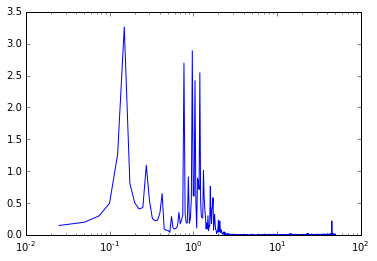

In [255]:
fft = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(signal.size, d=0.01)
plt.semilogx(freqs, np.abs(fft))

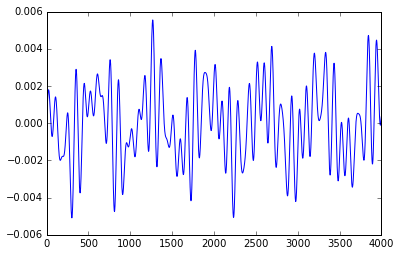

In [256]:
bad = np.abs(fft) > 2.5
plt.plot(np.fft.irfft(fft * bad))

(-0.01, 0.01)

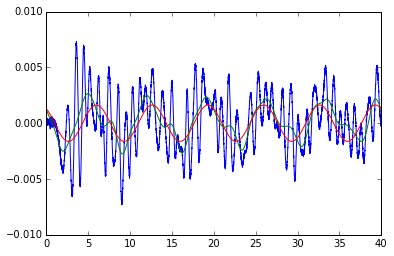

In [353]:
cfft = fft.copy()
cfft[freqs > 0.6] = 0

rsignal = np.fft.irfft(cfft)
plt.plot(t, signal)
plt.plot(t, rsignal)
plt.plot(t, cfft.max() / cfft.size * np.exp(2j * np.pi * t * freqs[cfft.argmax()]))
plt.ylim(-0.01, 0.01)

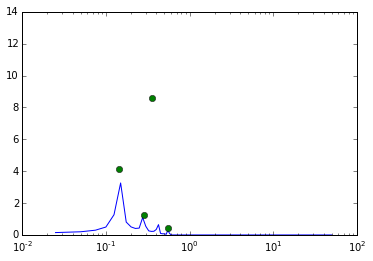

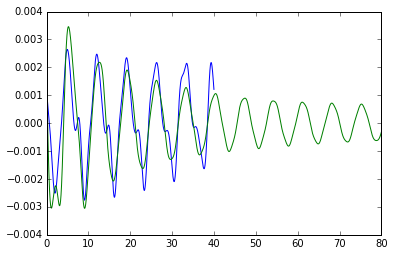

In [338]:
inv = harminv.Harminv(rsignal, fmin=0.05, fmax=1, dt=0.01)

plt.semilogx(freqs, np.abs(cfft))
plt.semilogx(inv.freq, inv.amplitude * rsignal.size, 'o')

t2 = np.linspace(0, 80, 8000)
plt.figure()
plt.plot(t, rsignal)
plt.plot(t2, inv.compute_modes(t2)[inv.decay > 0].sum(axis=0))

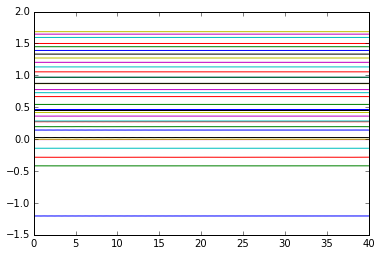

In [14]:
import harminv

inversion = harminv.Harminv(signal, fmin=0.01, fmax=4, dt=0.01)

for i, mode in enumerate(inversion.modes[inversion.Q > 100]):
    plt.plot(t, mode + inversion.freq[i])

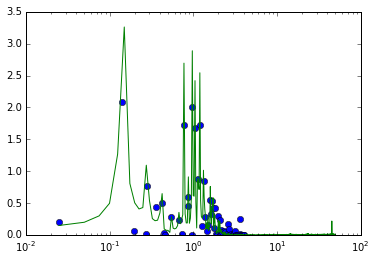

In [15]:
plt.semilogx(inversion.freq, 2000 * inversion.amplitude, 'o')

fft = np.fft.fft(signal)
freqs = np.fft.fftfreq(signal.size, d=0.01)
plt.semilogx(freqs, np.abs(fft))

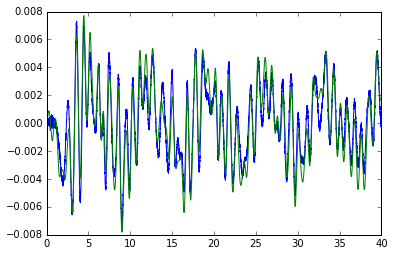

In [17]:
# compute the reconstructed signal
criterion = inversion.decay > 0
rsignal = inversion.modes[criterion].sum(axis=0)
plt.plot(t, signal)
plt.plot(t, rsignal * 1.5)

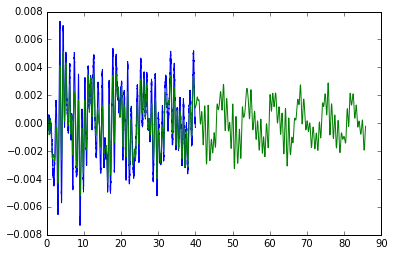

In [17]:
# compute the extended signal
te = r.T[0, 0, :]
emodes = inversion.compute_modes(te)
esignal = emodes[criterion].sum(axis=0)

plt.plot(t, signal)
plt.plot(te, esignal)

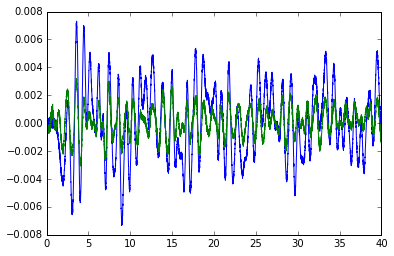

In [23]:
# now subtract from the data
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]

plt.plot(t, signal)
plt.plot(t, signal - rsignal)

#plt.contourf(mean_u - esignal.real, 100)

In [24]:
ri = reduced_inversion = harminv.Harminv(signal - rsignal, fmin=0.01, fmax=4, dt=0.01)

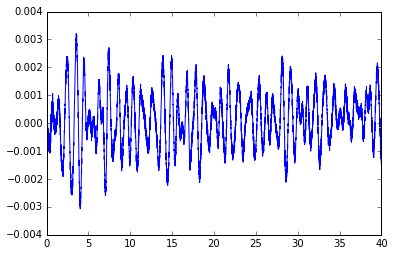

In [25]:
rrsignal = ri.modes[(ri.decay > 0) & (ri.Q > 100)].sum(axis=0)

plt.plot(t, signal - rsignal - rrsignal)
#plt.plot(t, rrsignal)

note: *(The other method to try is some form of autoregression, attempting to
extend the signal.)*

Are we approaching the noise floor of the signal?

In [26]:
rri = harminv.Harminv(signal - rsignal - rrsignal, fmin=0.5, fmax=8, dt=0.01)

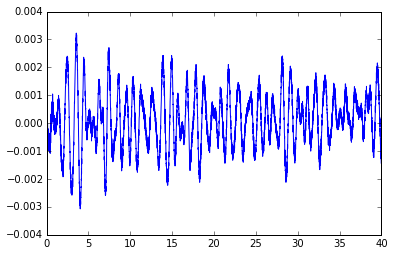

In [27]:
rrrsignal = rri.modes[(rri.decay > 0) & (rri.Q > 100)].sum(axis=0)

plt.plot(t, signal - rsignal - rrsignal - rrrsignal)

(-0.05, -0.07)

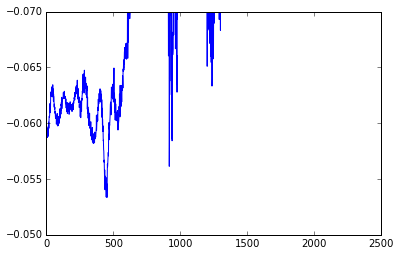

In [28]:
plt.plot(r.Uf[-10, 0, :4000])
plt.ylim(-0.05, -0.07)

### Application to the run

We wish to subtract this correction signal from our LAB relative data and then
transform to the FRONT relative frame.

In [90]:
r.ft = r.ft[:]  # overcome a bug in the api
transformer = g.turbulence.FrontTransformer(r)

In [29]:
extended_modes = inversion.compute_modes(te)
reduced_extended_modes = reduced_inversion.compute_modes(te)

ersignal = extended_modes[inversion.decay > 0].sum(axis=0)
errsignal = reduced_extended_modes[reduced_inversion.decay > 0].sum(axis=0)

correction = ersignal.real + errsignal.real

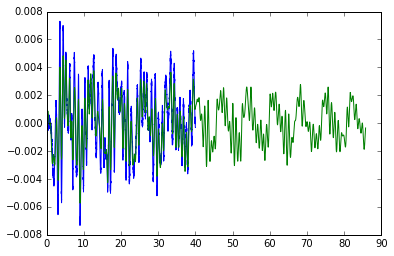

In [30]:
plt.plot(t, signal)
plt.plot(te, correction)

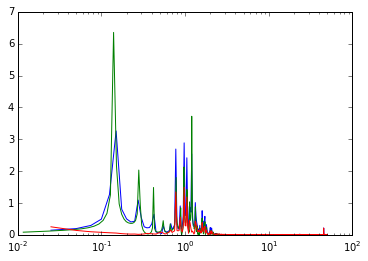

In [31]:
plt.semilogx(np.fft.rfftfreq(signal.size, d=0.01), np.abs(np.fft.rfft(signal)))
plt.semilogx(np.fft.rfftfreq(correction.size, d=0.01), np.abs(np.fft.rfft(correction)))
plt.semilogx(np.fft.rfftfreq(correction[:4000].size, d=0.01), np.abs(np.fft.rfft(signal - correction[:4000])))

In [32]:
corrected_data = r.U - correction

<matplotlib.contour.QuadContourSet instance at 0x7fbcc620f368>

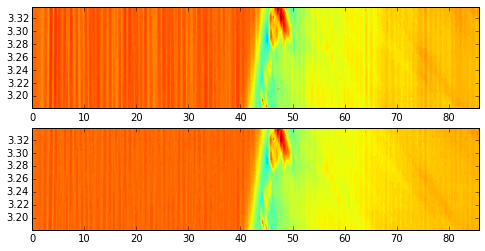

In [33]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 4))

axes[0].contourf(Te, r.X[0], mean_u, levels=u_levels)
axes[1].contourf(Te, r.X[0], mean_u - correction, levels=u_levels)

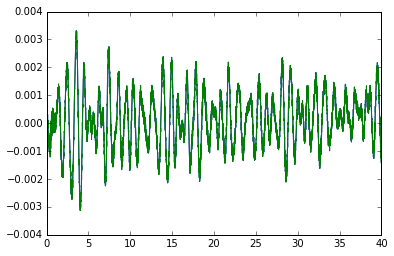

In [192]:
rcorr = np.mean(mean_u - correction, axis=0)
plt.plot(t, signal - correction[:4000])
plt.plot(t, rcorr[:4000])

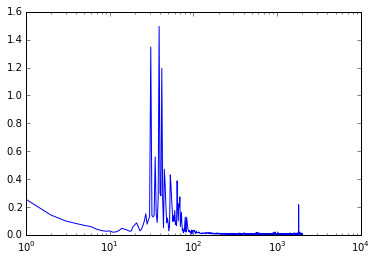

In [196]:
plt.semilogx(np.abs(np.fft.rfft(rcorr[:4000])))

In [35]:
inv = harminv.Harminv(signal - correction[:4000], fmin=0.7, fmax=1.5, dt=0.01)

(-0.002, 0.002)

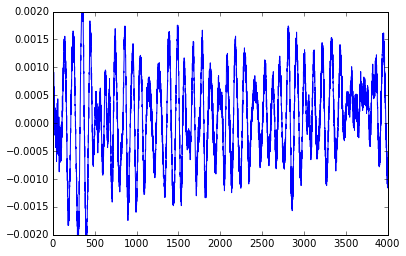

In [38]:
em = inv.compute_modes(te)
plt.plot(signal - correction[:4000] - em[inv.decay > 0].sum(axis=0)[:4000])

plt.xlim(0, 4000)
plt.ylim(-0.002, 0.002)

In [239]:
gobbler = g.turbulence.WaveGobbler(r)

In [27]:
waves = gobbler.get_waves(r.U)

<matplotlib.contour.QuadContourSet instance at 0x7f5bb279b248>

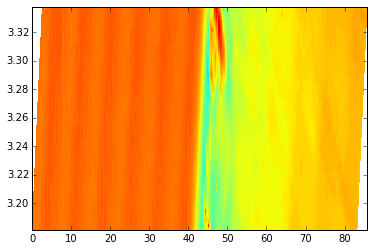

In [203]:
plt.contourf(Te, r.X[0], mean_u - waves[0], levels=u_levels)

Neither method entirely removes the waves. Perhaps a fusion will do the job?

In [204]:
iwaves = gobbler.get_waves(r.U - correction)

<matplotlib.colorbar.Colorbar instance at 0x7f5baa46d2d8>

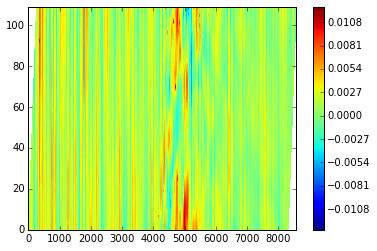

In [212]:
plt.contourf(waves[0], 100)
plt.colorbar()
#plt.contourf(Te, r.X[0], mean_u - iwaves[0], levels=u_levels)

In [209]:
cwaves = gobbler.get_clever_waves(r.U)

<matplotlib.colorbar.Colorbar instance at 0x7f5babeab830>

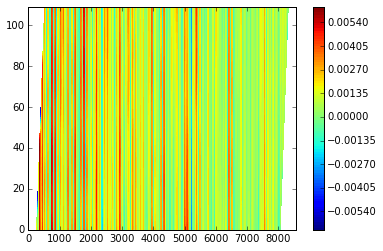

In [211]:
plt.contourf(cwaves[0], 100)
plt.colorbar()

In [28]:
icwaves = gobbler.get_clever_waves(corrected_data)

<matplotlib.contour.QuadContourSet instance at 0x7f8e77a752d8>

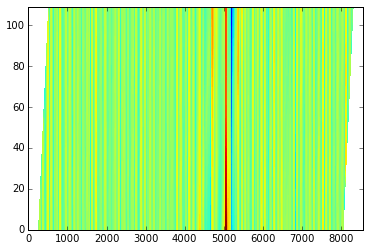

In [29]:
plt.contourf(icwaves[0], 100)

<matplotlib.contour.QuadContourSet instance at 0x7f8e6ed2cbd8>

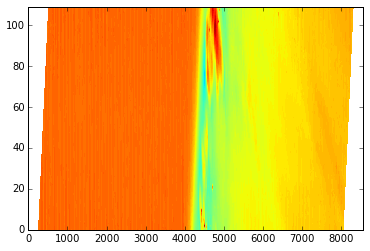

In [36]:
plt.contourf(mean_u - correction - icwaves[0], levels=u_levels)

In [89]:
residual = np.mean(mean_u - correction - icwaves[0], axis=0)[1000:4000]
#plt.plot(t, residual[:4000])
windowed_residual = residual * sig.kaiser(residual.size, 10)
plt.semilogx(np.abs(np.fft.rfft(windowed_residual)))
plt.semilogx(np.abs(np.fft.fft(signal[1000:4000])))

NameError: name 'icwaves' is not defined

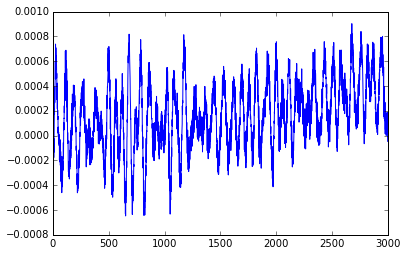

In [301]:
plt.plot(residual)

Another thing that we could attempt is just to flatten the fourier transform in
the region of the bad stuff.

Take the fourier transform and find what is needed to flatten it. Then construct
a longer signal using this bit.

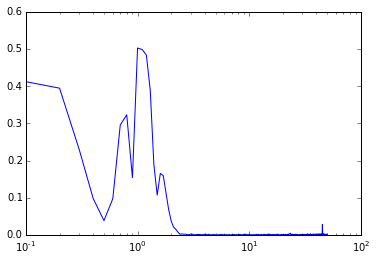

In [116]:
import scipy.signal as sig

kaiser = sig.kaiser(signal[:1000].size, 10)
windowed_signal = signal[:1000] * kaiser
rfs = np.fft.rfft(windowed_signal)
plt.semilogx(np.fft.rfftfreq(signal[:1000].size, d=0.01), np.abs(rfs))

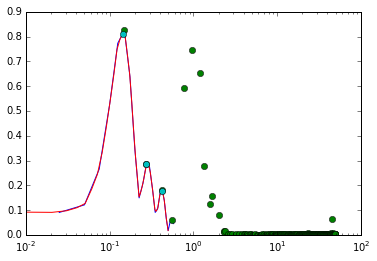

In [93]:
import scipy.ndimage as ndi
import scipy.interpolate as interp

freqs = np.fft.rfftfreq(signal.size, d=0.01)
fft = np.abs(rfs)

cut_fft = fft[freqs < 0.6]
cut_freqs = freqs[freqs < 0.6]

plt.plot(cut_freqs, cut_fft)

peaks = sig.find_peaks_cwt(-fft, widths=np.logspace(-2, 0))

plt.semilogx(freqs[peaks], fft[peaks], 'o')

s = interp.interp1d(cut_freqs, cut_fft)
x = np.linspace(0, 0.5)

plt.plot(x, s(x))

speaks = sig.find_peaks_cwt(-s(x), widths=np.logspace(-2, 0))

plt.plot(x[speaks], s(x)[speaks], 'o')

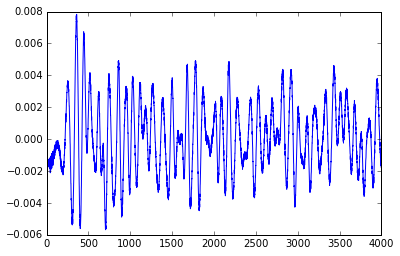

In [114]:
zrfs = np.zeros(rfs.size, dtype=np.complex)
zrfs[peaks] = rfs[peaks]
zrfs[freqs > 0.6] = 0
plt.plot(signal - np.fft.irfft(zrfs) * 4)
#plt.plot(signal)

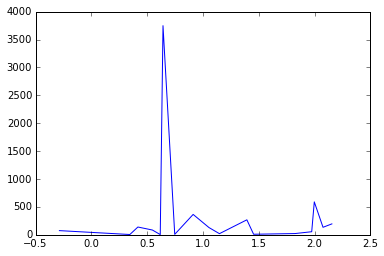

In [382]:
si = harminv.Harminv(signal, fmin=0.5, fmax=2, dt=0.01)
plt.plot(si.freq, np.abs(si.Q))

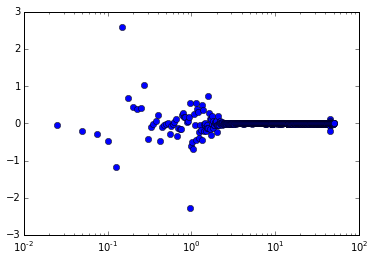

In [60]:
plt.semilogx(freqs, fft, 'o')

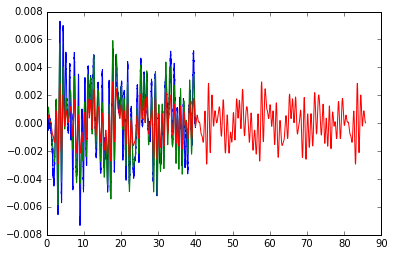

In [177]:
plt.plot(t, signal)
#plt.plot(t, c.sum(axis=0) / 2000)
plt.plot(t, 2 * c.sum(axis=0) / 4000)
plt.plot(te, ce.sum(axis=0) / 4000)
#plt.plot(t, signal - c.sum(axis=0) / 4000)

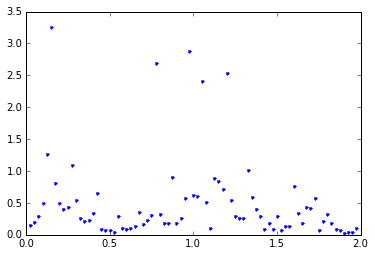

In [141]:
plt.plot(freqs[(freqs > 0) & (freqs < 2)], np.abs(fft[(freqs > 0) & (freqs < 2)]), '.')


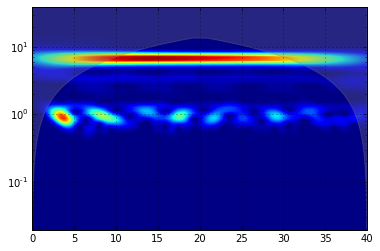

In [195]:
ax = wt.plot_power()

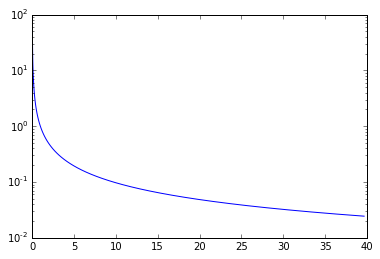

In [198]:
plt.semilogy(wt.scales, 1 / wt.fourier_periods)

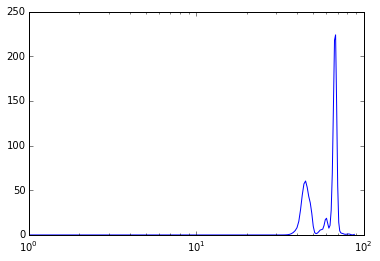

In [200]:
plt.semilogx(wt.global_wavelet_spectrum)

### Linear Predictive coding

In [41]:
# first detrend the signal
trend = np.polyfit(t, signal, 1)
dsignal = signal - (t * trend[0] + trend[1])

In [115]:
import spectrum

order = signal.size / 4
A, E, K = spectrum.arburg(dsignal, order=order)

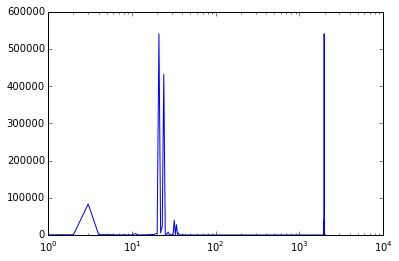

In [122]:
plt.semilogx(psd)

In [345]:
# now extend the data
y = np.zeros(te.size)
y[:4000] = dsignal

for i in range(4000, te.size):
    y[i] = np.sum(A[1:] * y[i-1:i-order:-1])

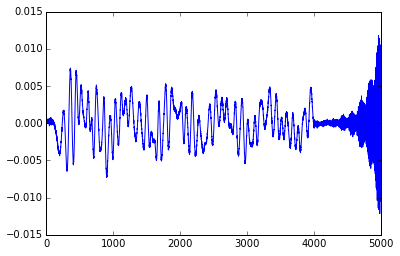

In [346]:
plt.plot(y[:5000])

In [373]:
# check our understanding by reconstructing the first part of the signal
y = np.zeros(t.size)
y[:order] = dsignal[:order]

for i in range(order, dsignal.size):
    y[i] = np.sum(A[1:] * y[i-order:i-1])

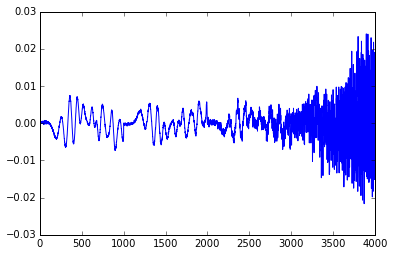

In [374]:
plt.plot(y)

<Container object of 3 artists>

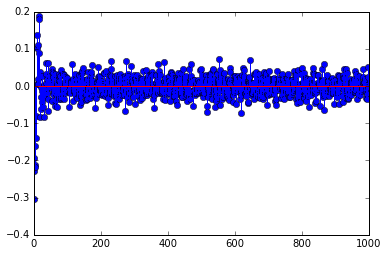

In [380]:
plt.stem(A)

### Statsmodels

In [62]:
import statsmodels.api as sm
import pandas

ewma = pandas.stats.moments.ewma

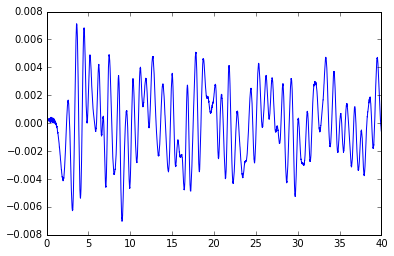

In [55]:
masignal = ewma(dsignal, com=2)
plt.plot(t, masignal)

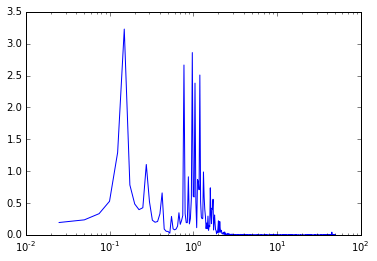

In [60]:
plt.semilogx(np.fft.rfftfreq(masignal.size, d=0.01), np.abs(np.fft.rfft(masignal)))

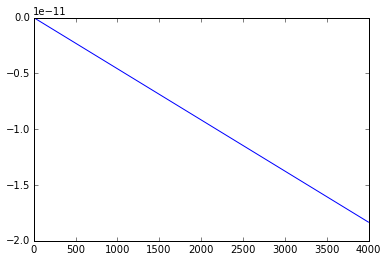

In [70]:
om = sm.OLS(dsignal, t)
olsres = om.fit()

plt.plot(olsres.predict(t))

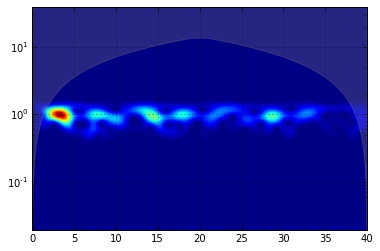

In [233]:
import wavelets

wt = wavelets.WaveletTransform(rcorr[:4000], unbias=True, dt=0.01)

wt.plot_power()

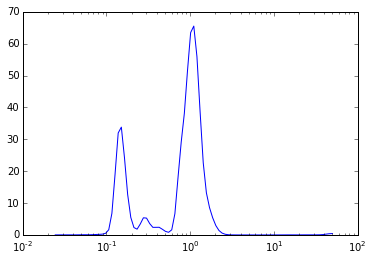

In [218]:
plt.semilogx(1 / wt.fourier_periods, wt.global_wavelet_spectrum)

In [141]:
def find_biggest_mode(signal):
    imax = np.argmax(np.abs(np.fft.rfft(signal)))
    amp = np.fft.rfft(signal)[imax]
    freq = np.fft.rfftfreq(signal.size, d=0.01)[imax]
    
    mode = 2 * amp * np.exp(2j * np.pi * freq * t) / signal.size
    return mode

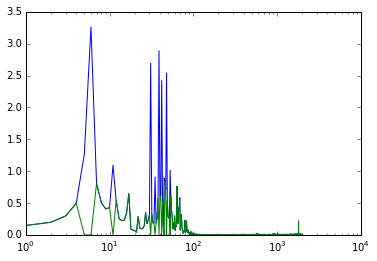

In [158]:
modes = []

s = signal.copy()
for i in range(10):
    mode = find_biggest_mode(s)
    s = s - mode
    modes.append(mode)
    
plt.semilogx(np.abs(np.fft.rfft(signal)))
plt.semilogx(np.abs(np.fft.rfft(s)))

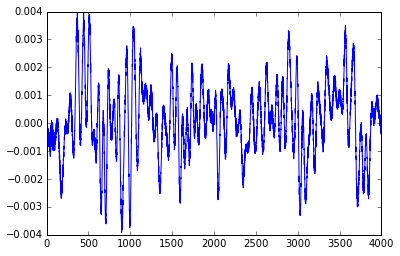

In [253]:
plt.plot(signal - sum(modes[:5]))

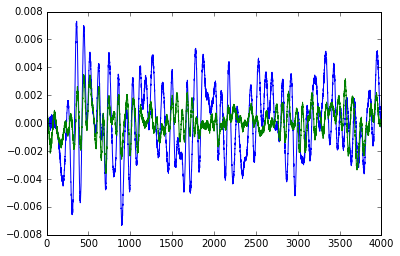

In [159]:
plt.plot(signal)
plt.plot(s)

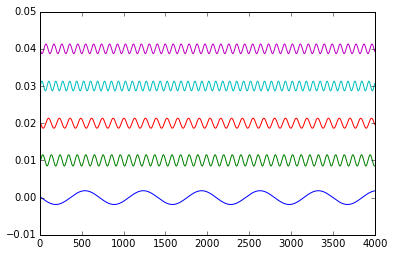

In [185]:
import scipy.optimize as opt

def find_biggest_mode(signal):
    imax = np.argmax(np.abs(np.fft.rfft(signal)))
    amp = np.fft.rfft(signal)[imax]
    freq = np.fft.rfftfreq(signal.size, d=0.01)[imax]
    return amp.real, freq, amp.imag

def f(t, amp, frequency, phase):
    return ((amp + 1j * phase) * np.exp(2j * np.pi * frequency * t)).real


s = signal.copy()

poppies = []
for i in range(5):
    popt, pcov = opt.curve_fit(f, t, s, p0=find_biggest_mode(s))
    s = s - f(t, *popt)
    poppies.append(popt)
    plt.plot(i / 100. + f(t, *popt))


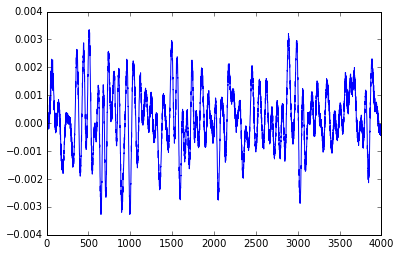

In [180]:
plt.plot(s)

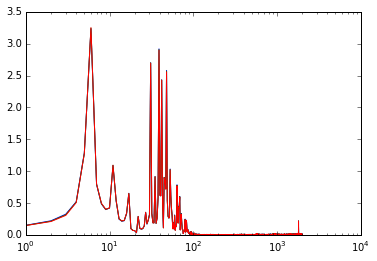

In [256]:
a = np.mean(r.U[-2:-1, :, :], axis=0).mean(axis=0)[:4000]
b = np.mean(r.U[-3:-2, :, :], axis=0).mean(axis=0)[:4000]
c = np.mean(r.U[-4:-3, :, :], axis=0).mean(axis=0)[:4000]

plt.semilogx(np.abs(np.fft.rfft(a)))
plt.semilogx(np.abs(np.fft.rfft(b)))
plt.semilogx(np.abs(np.fft.rfft(c)))

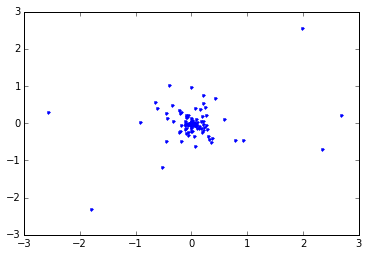

In [261]:
ft = np.fft.rfft(a)
plt.plot(ft.imag, ft.real, '.')

### AstroML

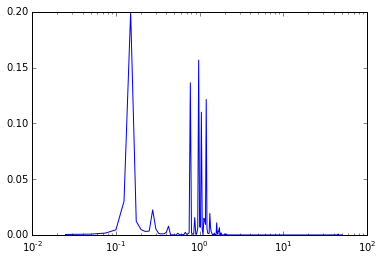

In [135]:
import astroML.time_series as ats

PS = ats.lomb_scargle(t, signal, 0.0001, 2*np.pi*freqs)
plt.semilogx(freqs, PS)
#plt.semilogx(freqs, rfs)

The Lomb Scargle periodogram is useful for identifying dominant periodic
frequencies.

We can see a dominant low frequency peak with what appear to be decreasing
amplitude modes above it. These surely represent our linear waves.

It is less clear what the cluster of frequencies around 1Hz comes from. This
could perhaps be instrumental noise.

It is possible that constructing the signal through averaging is causing this
clustering - perhaps the individual frequencies are confined somewhere.

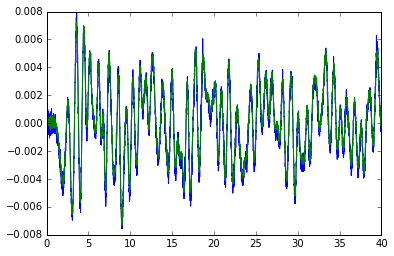

In [192]:
single_signal = r.U[-10, 50, :4000]
plt.plot(t, single_signal)
plt.plot(t, signal)

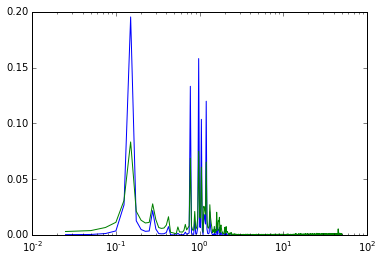

In [245]:
sPS = ats.lomb_scargle(t, single_signal, 0.0001, 2*np.pi*freqs)
plt.semilogx(freqs, sPS)
plt.semilogx(freqs, np.abs(np.fft.rfft(single_signal)) / 40)

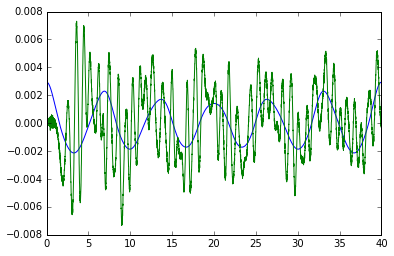

In [249]:
csPS = sPS.copy()
csPS[np.isnan(sPS)] = 0
csPS[freqs > 0.6] = 0

norm = single_signal.size * 0.01 / 2

plt.plot(t, np.fft.irfft(csPS) * norm)
plt.plot(t, signal)

This doesn't appear to be the case: a non averaged signal appears much the same.

Interestingly, the signal mean (which we are expecting to be zero) varies in
$(x, z)$:

<matplotlib.colorbar.Colorbar instance at 0x2ba92913a2d8>

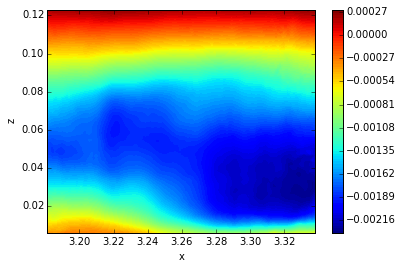

In [172]:
plt.contourf(r.X[:, :, 0].T, r.Z[:, :, 0].T, r.U[:, :, :3000].mean(axis=-1).T, 100)
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar()

Perhaps the frequencies in the cluster are localized in time. The wavelet
transform should give us a sense of this.

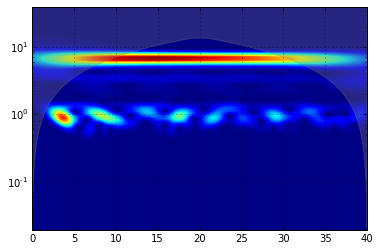

In [176]:
import wavelets

wt = wavelets.WaveletTransform(single_signal, dt=0.01)

wt.plot_power()

Whereas the low frequency power is constant through the time series, the 1Hz
power is localized.

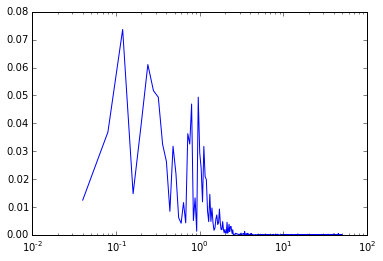

In [182]:
all_signal = mean_subtracted[20, 20, :]
all_t = r.Tf[20, 20, :]
all_freqs = np.fft.rfftfreq(all_t.size, d=0.01)
aPS = ats.lomb_scargle(all_t, all_signal, 0.001, 2 * np.pi * all_freqs)
plt.semilogx(all_freqs, aPS)

<matplotlib.colorbar.Colorbar instance at 0x2ba9421bd7a0>

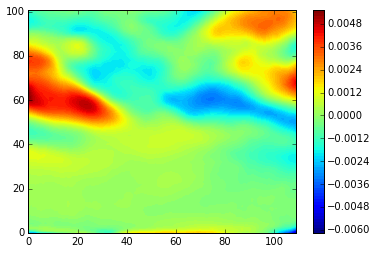

In [184]:
plt.contourf(mean_subtracted.mean(axis=-1), 100)
plt.colorbar()

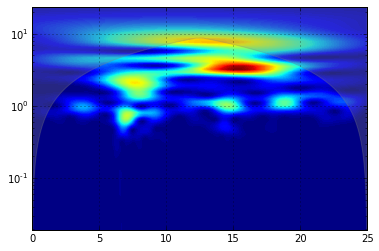

In [185]:
wt = wavelets.WaveletTransform(all_signal, dt=0.01)

wt.plot_power()

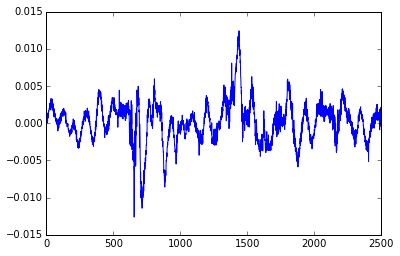

In [189]:
plt.plot(all_signal)

What if we look at the transverse velocity rather than the horizontal velocity?
This should be zero in the pre-current field.

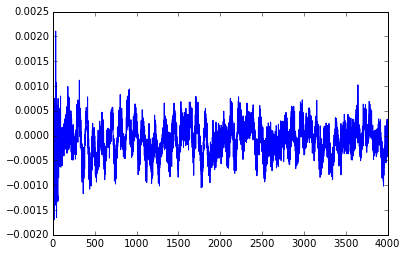

In [195]:
vsignal = np.mean(r.V[-10:, :, :], axis=0).mean(axis=0)[:4000]
plt.plot(vsignal)

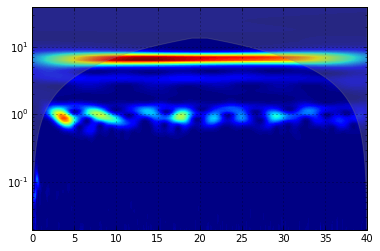

In [209]:
wavelets.WaveletTransform(vsignal, dt=0.01).plot_power()

The signal is smaller and more noisy but the power spectrum looks essentially
the same as that for the horizontal component.

What if we look at the v signal from the whole time series?

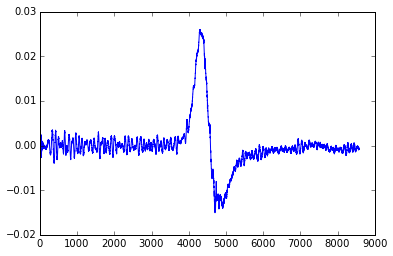

In [210]:
avsignal = np.mean(r.W[-5:, :, :], axis=0).mean(axis=0)
plt.plot(avsignal)

Clearly there is a problem with the angle of the light sheet.

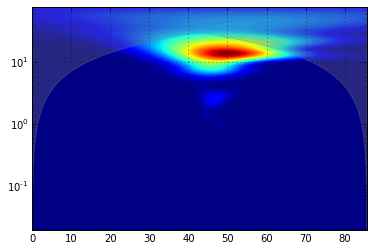

In [204]:
wavelets.WaveletTransform(avsignal, dt=0.01).plot_power()

Here's an idea for the removal process.

The linear waves are fairly easy to identify in the power spectrum and they are
constant frequency through the signal. Let's identify these waves using the pre-
current data and then extend them throughout the signal to subtract them.

Then we will remove the cluster of frequencies by the WaveGobbler wave
subtraction method, with the additional step of *band pass filtering the data
first* to avoid capturing too much other stuff.

Todo:

1. check other runs: do they have a cluster of frequencies around 1Hz?

<matplotlib.contour.QuadContourSet instance at 0x2ba968752488>

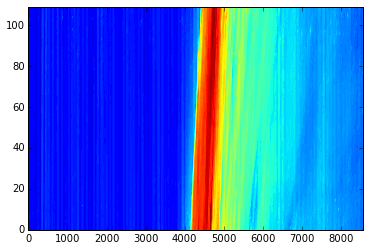

In [412]:
plt.contourf(r.U[40, :, :], 100)

<matplotlib.contour.QuadContourSet instance at 0x2ba96a7e1368>

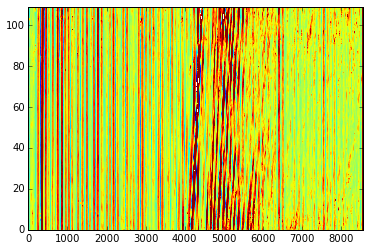

In [427]:
fft = np.fft.rfft(r.U[40, :, :], axis=-1)
freq = np.fft.rfftfreq(r.U.shape[-1], d=0.01)
power = np.abs(fft)

#plt.semilogx(freq, power[0])

rfft = fft.copy()
rfft[:, freq < 0.7] = 0  
rdata = np.fft.irfft(rfft, axis=-1)

levels = np.linspace(*np.percentile(rdata, (1, 99)))
plt.contourf(rdata, levels=levels)

Here's a trick. Take the fft of the data on the x axis and use a super-low pass
filter to only let the wave signal through:

<matplotlib.contour.QuadContourSet instance at 0x2ba9bd5eb878>

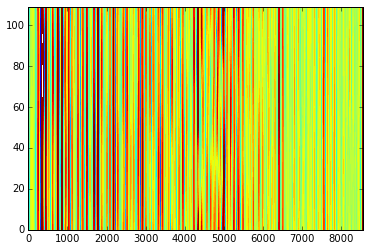

In [438]:
fft2 = np.fft.rfft(rdata, axis=0)
freq2 = np.fft.rfftfreq(rdata.shape[0])


rfft2 = fft2.copy()
rfft2[freq2 > 0.01, :] = 0
rdata2 = np.fft.irfft(rfft2, axis=0)

levels = np.linspace(*np.percentile(rdata2, (1, 99)))
plt.contourf(rdata2, levels=levels)

**The limit of a 'super low pass' filter is taking the mean across that axis
(the zero frequency DC component is equal to the mean). All we need to do is
perform the high pass filter across t and then average over both x and z to give
the wave signal in t.**

array([ 0.        ,  0.00909091,  0.01818182,  0.02727273,  0.03636364,
        0.04545455,  0.05454545,  0.06363636,  0.07272727,  0.08181818,
        0.09090909,  0.1       ,  0.10909091,  0.11818182,  0.12727273,
        0.13636364,  0.14545455,  0.15454545,  0.16363636,  0.17272727,
        0.18181818,  0.19090909,  0.2       ,  0.20909091,  0.21818182,
        0.22727273,  0.23636364,  0.24545455,  0.25454545,  0.26363636,
        0.27272727,  0.28181818,  0.29090909,  0.3       ,  0.30909091,
        0.31818182,  0.32727273,  0.33636364,  0.34545455,  0.35454545,
        0.36363636,  0.37272727,  0.38181818,  0.39090909,  0.4       ,
        0.40909091,  0.41818182,  0.42727273,  0.43636364,  0.44545455,
        0.45454545,  0.46363636,  0.47272727,  0.48181818,  0.49090909,
        0.5       ])

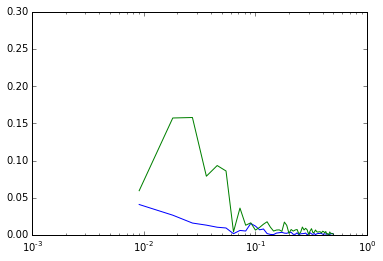

In [439]:
plt.semilogx(freq2, np.abs(fft2[:, 2000]))
plt.semilogx(freq2, np.abs(fft2[:, 5000]))

If we use the z axis we can do even better. Here is the filtering in it's
totality:

In [478]:
# can't get rfftn to do it in one go... might be a bug
fftn = np.fft.fftn(r.U[:, :, :])

ft = np.fft.fftfreq(r.U.shape[-1], d=0.01)
fx = np.fft.fftfreq(r.U.shape[0])
fz = np.fft.fftfreq(r.U.shape[1])

fftn[1:, :, :] = 0
fftn[:, 1:, :] = 0
fftn[:, :, np.abs(ft) < 0.70] = 0

rdata = np.fft.ifftn(fftn).real

In [453]:
fx.shape, fz.shape, ft.shape, fftn.shape

((52,), (56,), (4289,), (102, 110, 4289))

<matplotlib.contour.QuadContourSet instance at 0x2baa6901a830>

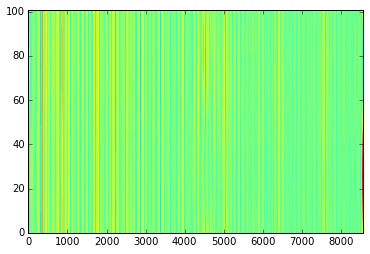

In [509]:
plt.contourf(rdata[:, 20, :], 100)

<matplotlib.contour.QuadContourSet instance at 0x2badd13f6908>

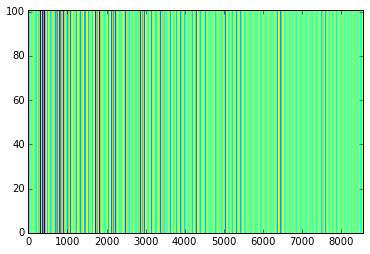

In [534]:
# this way we only use the zero frequency components
fftn = np.fft.fftn(r.U[:, :, :])

fftn[1:, :, :] = 0
fftn[:, 1:, :] = 0
fftn[:, :, np.abs(ft) < 0.70] = 0

srdata = np.fft.ifftn(fftn).real
plt.contourf(srdata[:, 20, :], 100)

In [578]:
afft = np.fft.rfft(r.U, axis=-1)
afft[:, :, freq < 0.7] = 0
adata = np.fft.irfft(afft, axis=-1).mean(axis=0).mean(axis=0)

(0, 6000)

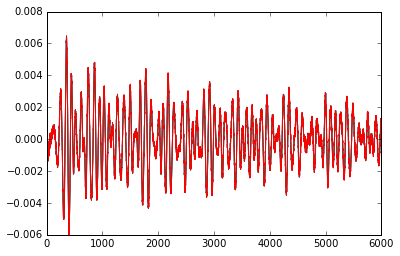

In [581]:
#plt.plot(rdata[50, 20])
plt.plot(srdata[50, 20])
plt.plot(rdata.mean(axis=0).mean(axis=0))
plt.plot(adata)
plt.xlim(0, 6000)

<matplotlib.contour.QuadContourSet instance at 0x2ba9c8bed7e8>

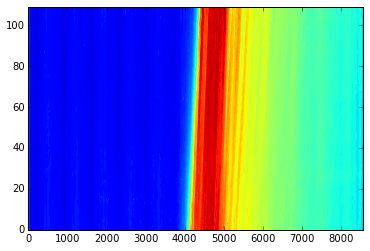

In [507]:
plt.contourf(r.U[20] - rdata[20], 100)

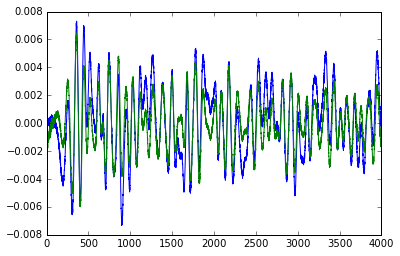

In [492]:
fftsignal = rdata.mean(axis=0).mean(axis=0)
plt.plot(signal)
plt.plot(fftsignal[:4000])

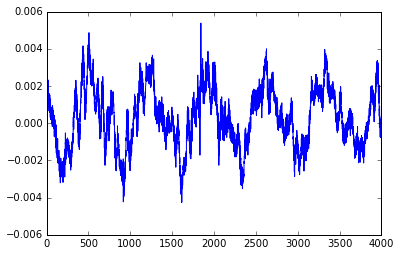

In [508]:
plt.plot((r.U - rdata)[-1, 10, :4000])

That works well enough for the higher frequency component of the waves. Let's
have a look at the wavelet transform now:

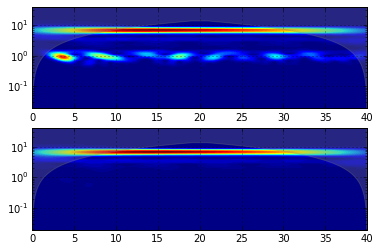

In [499]:
fft_sub_signal = r.U[-10, 50, :4000] - fftsignal[:4000]

fig, axes = plt.subplots(nrows=2)

wt = wavelets.WaveletTransform(single_signal, dt=0.01)
wt.plot_power(axes[0])

fwt = wavelets.WaveletTransform(fft_sub_signal, dt=0.01)
fwt.plot_power(axes[1])

That looks much better. Now we just need to get rid of the low frequency waves
that occur throughout the signal.

One useful thing about these lower frequency waves is that their frequency never
goes lower than 0.1 (xxx from scale = 10 in morlet wavelet).

Look at the wavelet transform over all of the signal:

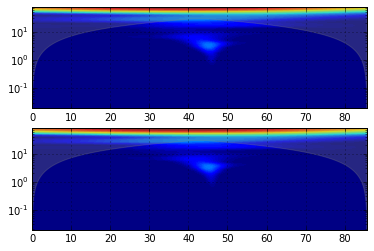

In [518]:
all_fft_sub_signal = r.U[-10, 50] - fftsignal
all_signal = r.U[-10, 50]

fig, axes = plt.subplots(nrows=2)

wt = wavelets.WaveletTransform(all_signal, dt=0.01)
wt.plot_power(axes[0])

fwt = wavelets.WaveletTransform(all_fft_sub_signal, dt=0.01)
fwt.plot_power(axes[1])

In [536]:
sub_data = r.U - fftsignal

<matplotlib.contour.QuadContourSet instance at 0x2bafc8053248>

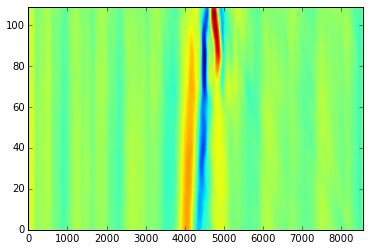

In [551]:
sub_fft = np.fft.fft(sub_data, axis=-1)
sub_fft[:, :, np.abs(ft) < 0.08] = 0
sub_fft[:, :, np.abs(ft) > 0.5] = 0
rsub = np.fft.ifft(sub_fft, axis=-1)
plt.contourf(rsub[-1, :, :], 100)

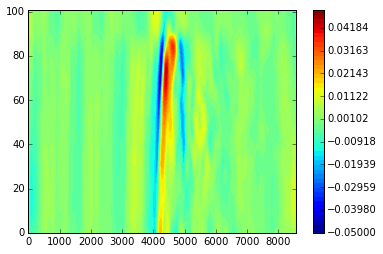

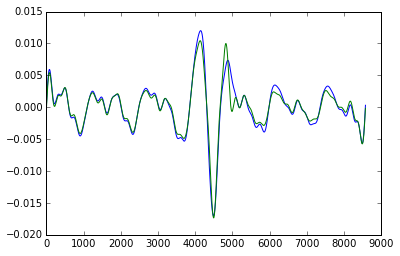

In [585]:
plt.contourf(rsub[:, 20, :], levels=np.linspace(-0.05, 0.05))
plt.colorbar()
plt.figure()
plt.plot(rsub[-1, 50])
plt.plot(rsub.mean(axis=1)[-1])

<matplotlib.contour.QuadContourSet instance at 0x2bafe082e7a0>

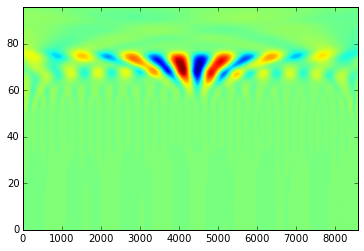

In [559]:
swt = wavelets.WaveletTransform(rsub[-1, 50])
plt.contourf(swt.wavelet_transform.real, 100)

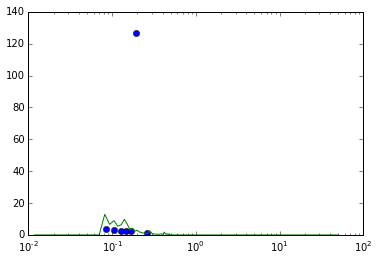

In [565]:
rharm = harminv.Harminv(rsub[-1, 50], dt=0.01, fmin=0.05, fmax=0.15)
plt.semilogx(rharm.freq, 2000 * rharm.amplitude, 'o')

rfft = np.fft.fft(rsub[-1, 50])
rfreqs = np.fft.fftfreq(rsub.shape[-1], d=0.01)
plt.semilogx(rfreqs, np.abs(rfft))

In [587]:
transformer = g.turbulence.FrontTransformer(r)

rsubf = transformer.to_front(rsub.real, order=0)

In [594]:
mrsubf = rsubf - rsubf.mean(axis=1, keepdims=1)
mrsub = transformer.to_lab(mrsubf, order=0)

<matplotlib.contour.QuadContourSet instance at 0x2bb243626710>

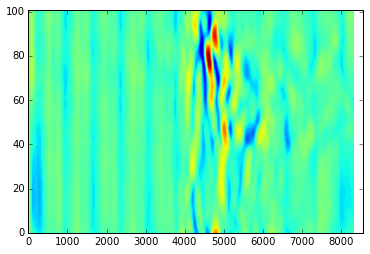

In [595]:
plt.contourf(mrsub[:, 0], 100)

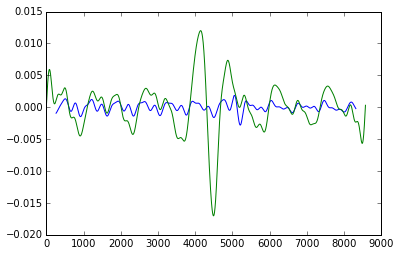

In [598]:
s = mrsub.mean(axis=0).mean(axis=0)
plt.plot(s)
plt.plot(rsub[-1, 50])

array([-0.00137813, -0.00039497, -0.00052867,  0.00023262, -0.00779007,
        0.01080833,  0.0985932 ,  0.0426646 ])

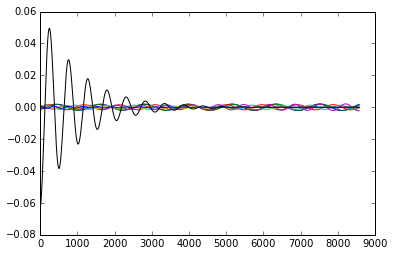

In [569]:
plt.plot(rharm.modes.T)
rharm.decay

In [521]:
fftn = np.fft.fftn(r.U[:, :, :])

fftn[np.abs(fx) > 0.01, :, :] = 0
fftn[:, np.abs(fz) > 0.01, :] = 0
fftn[:, :, np.abs(ft) > 0.70] = 0
fftn[:, :, np.abs(ft) < 0.10] = 0
ardata = np.fft.ifftn(fftn)

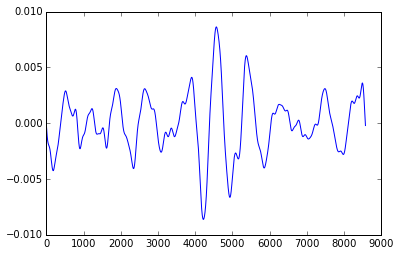

In [522]:
afftsignal = ardata.dhmean(axis=0).mean(axis=0)
plt.plot(afftsignal)

In [627]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2)

S = (r.U - rdata)[:, 0].real.T

X = ica.fit_transform(S)

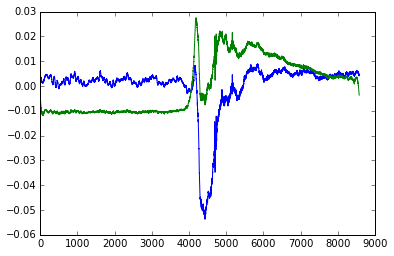

In [628]:
plt.plot(X)

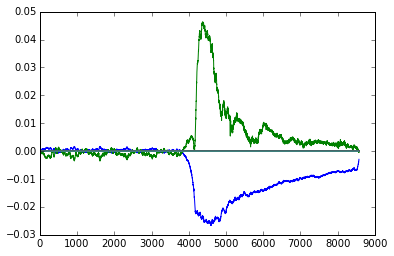

In [634]:
from sklearn.decomposition import SparsePCA

pca = SparsePCA()

pcat = pca.fit_transform(S)

plt.plot(pcat)

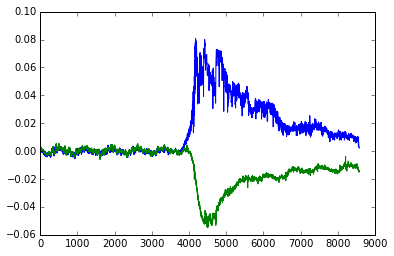

In [633]:
plt.plot(S[:, 0])
plt.plot(S[:, -1])

In [635]:
import pyhht

ImportError: No module named pyhht